In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

import gc
import os

In [3]:
anime_info = pd.read_csv('../data/anime.csv')
ratings = pd.read_csv('../data/rating_complete.csv') #all rating with watchingstatus == 2 (completed watching)
watch_status = pd.read_csv('../data/watching_status.csv')

In [4]:
print(f"Anime Info table: number of anime: {anime_info.shape[0]} number of features: {anime_info.shape[1]}" )
print(f"Anime list with watching status 'completed' (rating table): number of records: {ratings.shape[0]} number of features: {ratings.shape[1]}" )

Anime Info table: number of anime: 17562 number of features: 35
Anime list with watching status 'completed' (rating table): number of records: 57633278 number of features: 3


In [5]:
anime_df = anime_info.rename(columns = {'Rating':'age_rating', 'MAL_ID':'anime_id'})

In [6]:
def description(data):
    types=data.dtypes
 
    counts=data.apply(lambda x: x.count())
    unique_values=data.apply(lambda x: x.unique())
    nulls=data.apply(lambda x: x.isnull().sum())
    distincts=data.apply(lambda x: x.unique().shape[0])
    cols={'dtypes':types, 'counts':counts,  'nulls':nulls,
         'unique':distincts,'unique_values':unique_values}
    table=pd.DataFrame(data=cols)
    return table

In [7]:
description(anime_df)

,dtypes,counts,nulls,unique,unique_values
anime_id,int64,17562,0,17562,"[1, 5, 6, 7, 8, 15, 16, 17, 18, 19, 20, 21, 22..."
Name,object,17562,0,17558,"[Cowboy Bebop, Cowboy Bebop: Tengoku no Tobira..."
Score,object,17562,0,533,"[8.78, 8.39, 8.24, 7.27, 6.98, 7.95, 8.06, 7.5..."
Genres,object,17562,0,5034,"[Action, Adventure, Comedy, Drama, Sci-Fi, Spa..."
English name,object,17562,0,6831,"[Cowboy Bebop, Cowboy Bebop:The Movie, Trigun,..."
Japanese name,object,17562,0,16679,"[カウボーイビバップ, カウボーイビバップ 天国の扉, トライガン, Witch Hunte..."
Type,object,17562,0,7,"[TV, Movie, OVA, Special, ONA, Music, Unknown]"
Episodes,object,17562,0,201,"[26, 1, 52, 145, 24, 74, 220, Unknown, 178, 12..."
Aired,object,17562,0,11947,"[Apr 3, 1998 to Apr 24, 1999, Sep 1, 2001, Apr..."
Premiered,object,17562,0,231,"[Spring 1998, Unknown, Summer 2002, Fall 2004,..."


In [8]:
def make_anime_score_rank_float(df):
    # convert object to a numeric type, replacing Unknown with 0.
    #Score column contains the average of all the score given by the users to this anime
    df['Score'] = df['Score'].apply(lambda x: 0 if x=='Unknown' else float(x)) 
    df['Ranked'] = df['Ranked'].apply(lambda x: 0 if x=='Unknown' else float(x)) 

    for i in range(1, 11):
        #Score-{1-10} column contains number of users who scored the anime with the respective score
        df[f'Score-{i}'] = df[f'Score-{i}'].apply(lambda x: 0 if x=='Unknown' else float(x)) 
    return df

In [9]:
anime_df = make_anime_score_rank_float(anime_df)

In [10]:
def add_genre_to_features(df):
    genres = df.Genres.unique()
    genres_set = []
    genres_dict = defaultdict(int)
    for val in genres:
        tokens = val.split(',')
        for i in range(len(tokens)):
            if tokens[i].strip().lower() not in genres_set:
                genres_set.append(tokens[i].strip().lower())
        
    
    d = {name :[] for name in genres_set}

    def f(row):
        genres_row = row.Genres.split(',')
        for i in range(len(genres_row)):
            genres_row[i] = genres_row[i].strip().lower()
        for genre in genres_set:
            if genre in genres_row:
                d[genre].append(1)
                genres_dict[genre] +=1
            else:
                d[genre].append(0)
            
        
    
    df.apply(f, axis=1)
    genre_df = pd.DataFrame(d, columns=genres_set)
    
    df = pd.concat([df, genre_df], axis=1)
    
    
    return df

In [11]:
anime_df= add_genre_to_features(anime_df)

In [12]:
anime_df = anime_df.drop('Genres', axis=1)

In [13]:
ratings_desc=description(ratings)

<AxesSubplot:ylabel='unique'>

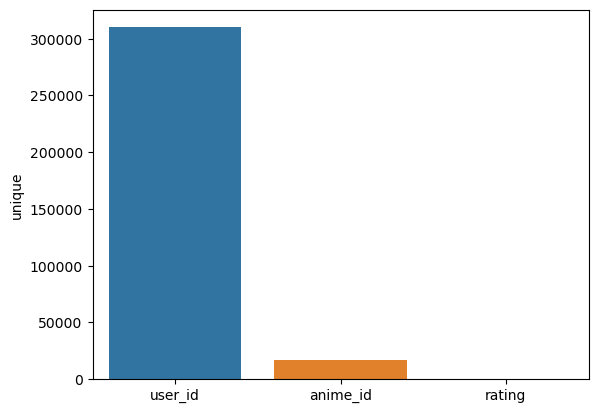

In [14]:
sns.barplot(x = ratings.columns, y=ratings_desc['unique'])

Text(0.5, 1.0, 'Distribution of rating')

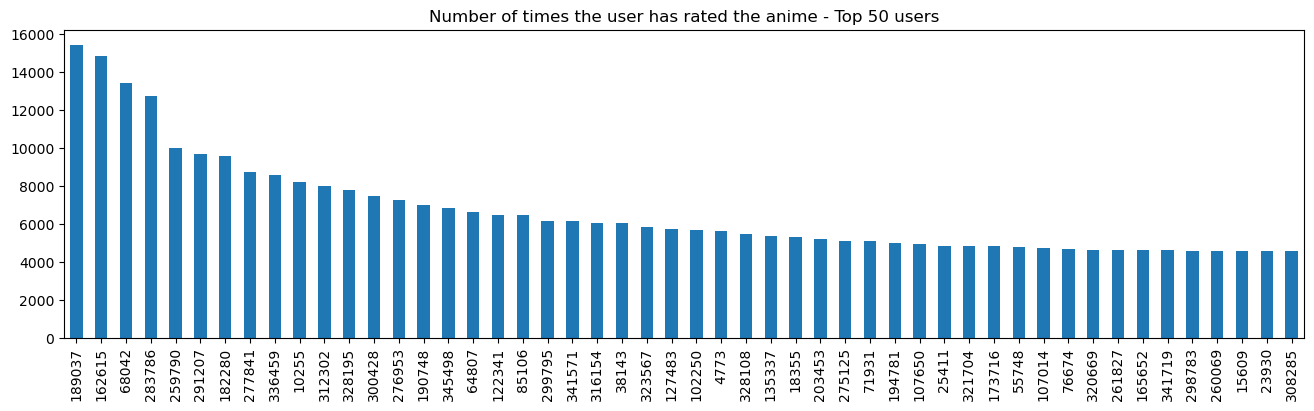

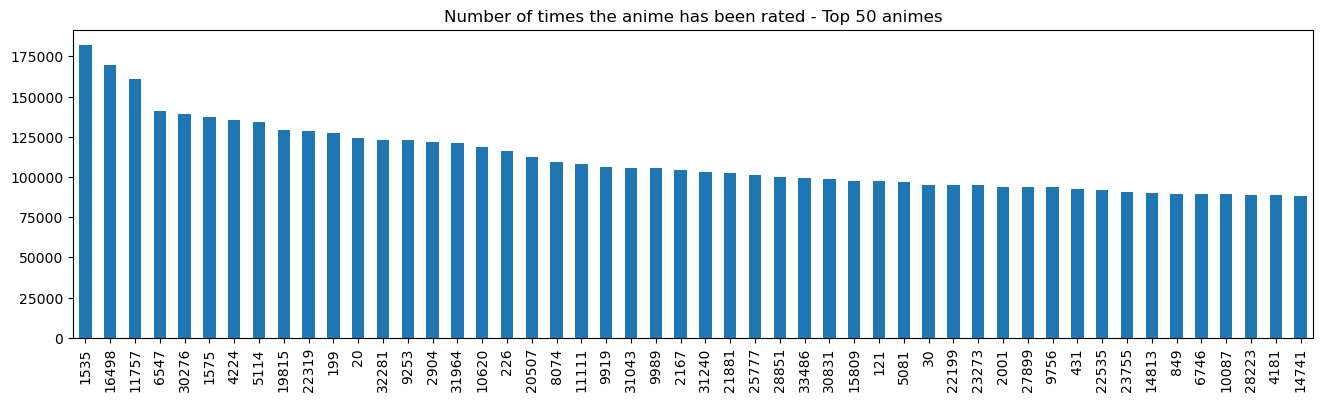

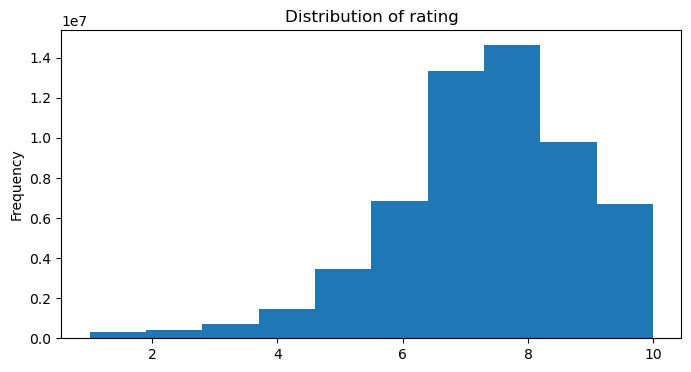

In [15]:
plt.figure(1,figsize = (16,4))
ratings['user_id'].value_counts()[:50].plot(kind='bar')
plt.title('Number of times the user has rated the anime - Top 50 users')
plt.figure(2,figsize = (16,4))
ratings['anime_id'].value_counts()[:50].plot(kind='bar')
plt.title('Number of times the anime has been rated - Top 50 animes')


plt.figure(3,figsize = (8,4))
ratings['rating'].plot(kind='hist')
plt.title('Distribution of rating')


<AxesSubplot:>

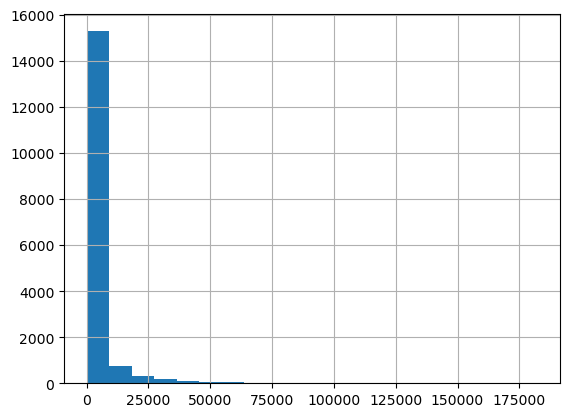

In [16]:
num_users_vote_r = ratings.groupby('anime_id')['rating'].agg('count')
num_anime_vote_r = ratings.groupby('user_id')['rating'].agg('count')
num_users_vote_r.hist(bins = 20)

<AxesSubplot:>

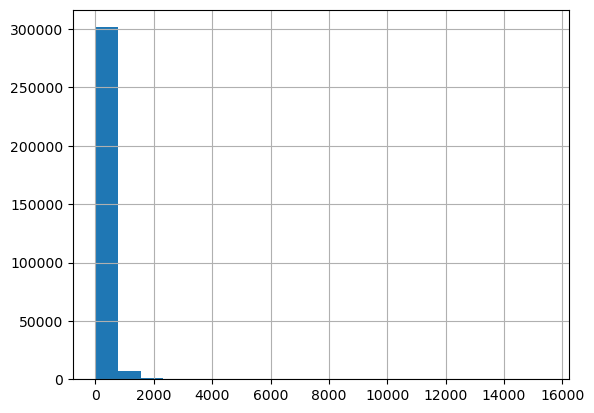

In [17]:
num_anime_vote_r.hist(bins = 20)

Let's still take a smaller sample to be able to keep the kernel running while creating a pivot for this dataframe. Also, let's add some filters to the ratings dataset. Data points are mostly collected from very popular movies and highly engaged users. We wouldn’t want movies that were rated by a small number of users because it’s not credible enough. Similarly, users who have rated only a handful of movies should also not be taken into account.: To qualify a movie, atleast 10 users should have rated it. and to qualify a user's rating, the user should have rated atleast 75 movies.

In [18]:
rating_frac = ratings.sample(frac=0.01, random_state=12)

In [19]:
rating_frac.shape

(576333, 3)

In [20]:
description(rating_frac)

,dtypes,counts,nulls,unique,unique_values
user_id,int64,576333,0,189479,"[84166, 2195, 297830, 106832, 156791, 313422, ..."
anime_id,int64,576333,0,11659,"[38691, 31181, 225, 31339, 10431, 1723, 31043,..."
rating,int64,576333,0,10,"[9, 8, 5, 4, 7, 6, 10, 1, 3, 2]"


Text(0.5, 1.0, 'Distribution of rating')

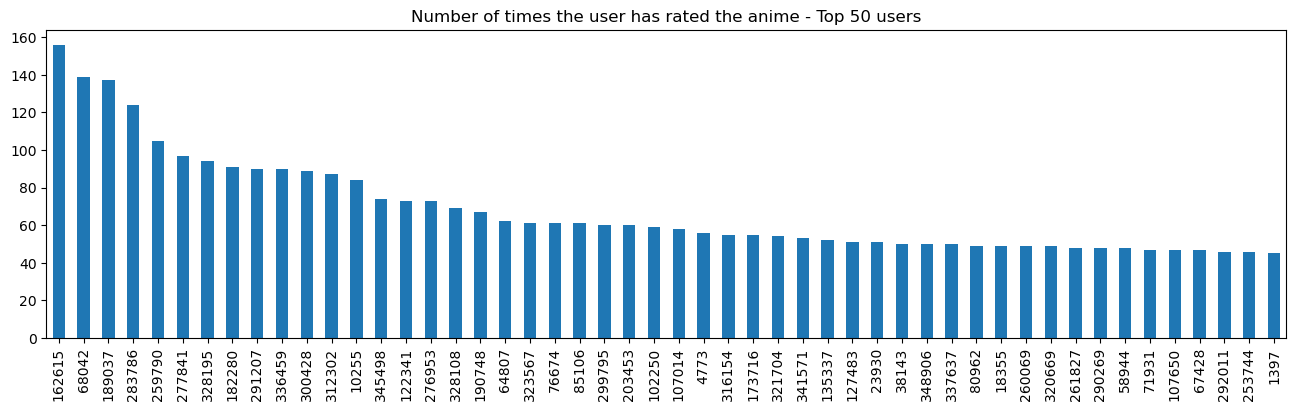

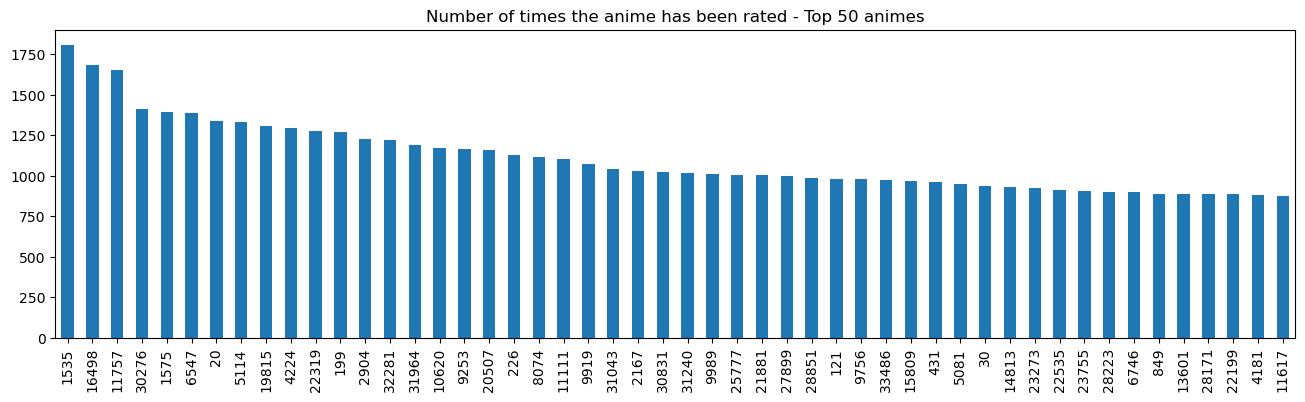

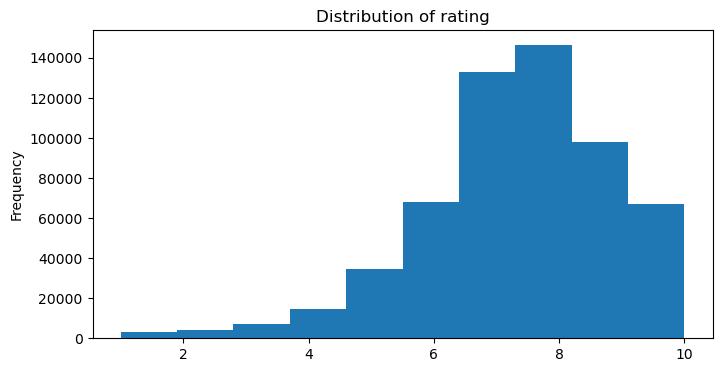

In [29]:
plt.figure(1,figsize = (16,4))
rating_frac['user_id'].value_counts()[:50].plot(kind='bar')
plt.title('Number of times the user has rated the anime - Top 50 users')
plt.figure(2,figsize = (16,4))
rating_frac['anime_id'].value_counts()[:50].plot(kind='bar')
plt.title('Number of times the anime has been rated - Top 50 animes')


plt.figure(5,figsize = (8,4))
rating_frac['rating'].plot(kind='hist')
plt.title('Distribution of rating')

<AxesSubplot:>

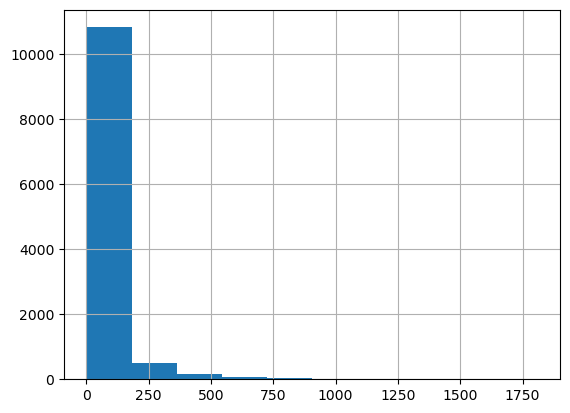

In [33]:
num_users_vote = rating_frac.groupby('anime_id')['rating'].agg('count')
num_anime_vote = rating_frac.groupby('user_id')['rating'].agg('count')
num_users_vote.hist()

<AxesSubplot:>

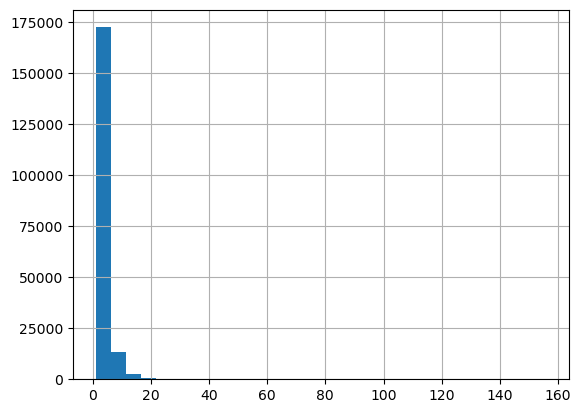

In [39]:
num_anime_vote.hist(bins=30)

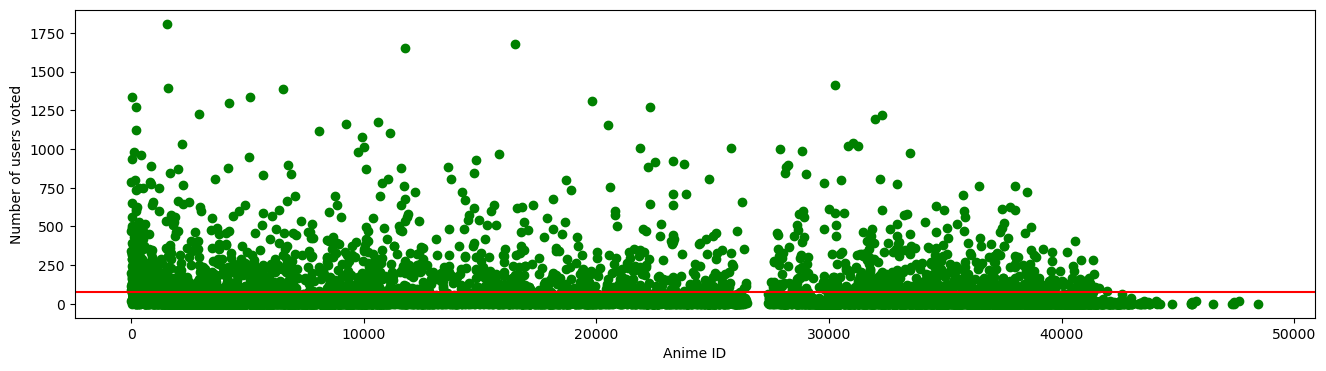

In [27]:
f,ax = plt.subplots(1,1, figsize=(16,4))
plt.scatter(num_users_vote.index, num_users_vote,color = 'g')
plt.axhline(y=75, color='r')
plt.xlabel('Anime ID')
plt.ylabel('Number of users voted')
plt.show()

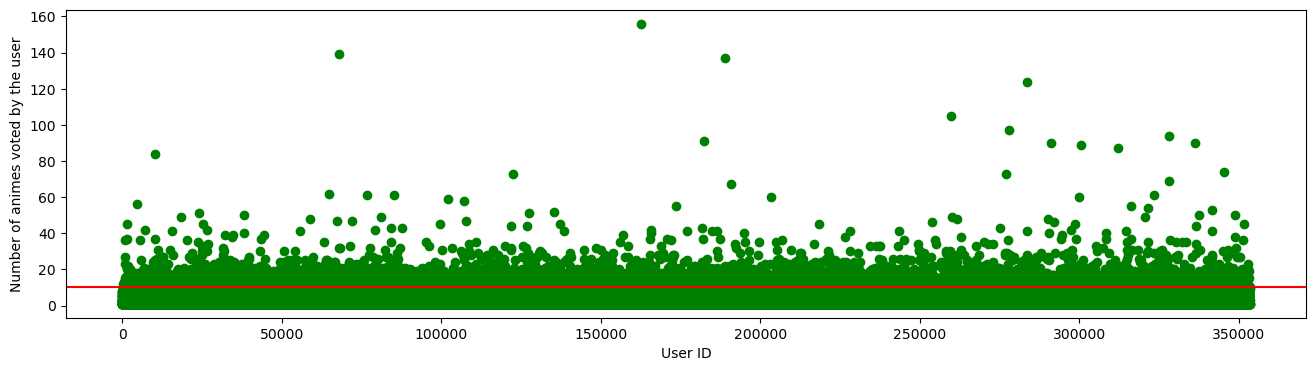

In [28]:
f,ax = plt.subplots(1,1, figsize=(16,4))
plt.scatter(num_anime_vote.index, num_anime_vote,color = 'g')
plt.axhline(y=10, color='r')
plt.xlabel('User ID')
plt.ylabel('Number of animes voted by the user')
plt.show()

In [29]:
user_filt=num_anime_vote[num_anime_vote > 10 ].index
anime_filt=num_users_vote[num_users_vote > 75].index

In [30]:
rating_knn = rating_frac[rating_frac['user_id'].isin(user_filt)]
rating_knn = rating_knn[rating_knn['anime_id'].isin(anime_filt)]

<AxesSubplot:>

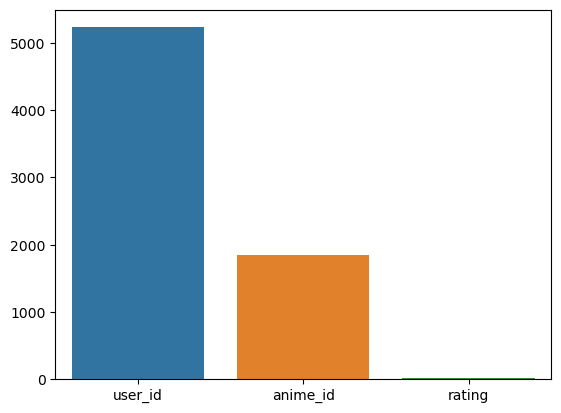

In [22]:
sns.barplot(x=rating_knn.columns,y=rating_knn.nunique(axis=0))

In [23]:
pivot = pd.pivot_table(rating_knn,index='anime_id',columns='user_id', values='rating')

In [24]:
pivot

user_id,314,446,493,590,603,781,853,876,890,912,...,352748,352761,352832,352835,352922,352930,353049,353075,353325,353326
anime_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
pivot.fillna(0, inplace=True)

In [26]:
pivot

user_id,314,446,493,590,603,781,853,876,890,912,...,352748,352761,352832,352835,352922,352930,353049,353075,353325,353326
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
def calculate_sparsity(matrix):
    sparsity= 1- (np.count_nonzero(matrix)/(matrix.size))
 
    return sparsity 

In [28]:
calculate_sparsity(pivot)

0.9951988784474588

In [29]:
csr_data = csr_matrix(pivot.values)

In [30]:
pivot_final = pivot.reset_index()

## Model 1 - Item-based recommendation : NearestNeighbors 

Given a anime name, we have used the NearestNeighbors to recommend 10 similar animes based on its score using Cosine similarity.

In [78]:
knn = NearestNeighbors(metric='cosine', algorithm = 'auto', n_neighbors=100, n_jobs=-1)

In [79]:
knn.fit(csr_data)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=100)

In [88]:
def get_recommendation_for(anime):
    pred_df = anime_df.merge(rating_knn, on='anime_id', how='inner' )
    l = pred_df[pred_df.Name.str.contains(anime)]
    if len(l):
        id=l.iloc[0]['anime_id']
        score = l.iloc[0]['Score']
        try:
            ids = pivot_final[pivot_final['anime_id'] == id].index[0]
            dist, ind = knn.kneighbors(csr_data[ids], n_neighbors=10)
            mov = sorted(list(zip(ind.squeeze().tolist(),dist.squeeze().tolist())),key = lambda x: x[1])[:0:-1]
            rec=[]
            for val in mov:
                id = pivot_final.iloc[val[0]]['anime_id']
                name = pred_df[pred_df.anime_id == id]['Name'].values[0]
                scores = pred_df[pred_df.anime_id == id]['Score'].values[0]
                rec.append({"Anime":name,"Score":scores, "Distance": val[1]})
            rec_df=pd.DataFrame(rec)
            print(f'The overall score for the anime, {anime}, is {score}')
            return rec_df
        except:
            return "No Movies Found"
    else:
        return "No movies found"

    

In [89]:
get_recommendation_for('Cowboy Bebop')

The overall score for the anime, Cowboy Bebop, is 8.78


,Anime,Score,Distance
0,Diamond no Ace: Second Season,8.32,0.930311
1,Fullmetal Alchemist: Premium Collection,7.35,0.929910
2,Rozen Maiden,7.44,0.925376
3,Okusama ga Seitokaichou!+!,6.65,0.924135
4,Murder Princess,7.02,0.923775
5,ChäoS;Child,6.39,0.922198
6,Hidan no Aria,6.88,0.922051
7,"Uchi no Ko no Tame naraba, Ore wa Moshikashita...",7.04,0.911138
8,Rewrite 2nd Season,7.26,0.909580


In [90]:
get_recommendation_for('Trigun')

The overall score for the anime, Trigun, is 8.24


,Anime,Score,Distance
0,Ichiban Ushiro no Daimaou,6.89,0.932054
1,Mob Psycho 100,8.49,0.930622
2,A-Channel,6.96,0.928918
3,Nisekoi:,7.39,0.928184
4,Hikaru no Go,8.11,0.927974
5,Mahou Shoujo Lyrical Nanoha,7.42,0.923088
6,Sakamoto Desu ga?,7.59,0.918952
7,Yu☆Gi☆Oh!: Hikari no Pyramid,6.59,0.905254
8,Dragon Ball Z Movie 13: Ryuuken Bakuhatsu!! Go...,7.34,0.904416


In [83]:
get_recommendation_for('Isaku: Respect')

'No movies found'

In [37]:
merged_df = pd.merge(anime_df, rating_frac, on='anime_id')

In [38]:
del ratings
gc.collect()

3244

In [39]:
merged_df.sample(10)

,anime_id,Name,Score,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,...,shoujo ai,shounen ai,kids,hentai,parody,yuri,yaoi,unknown,user_id,rating
127292,2273,Mobile Suit Gundam Wing: Endless Waltz Movie,7.81,Mobile Suit Gundam Wing:Endless Waltz,新機動戦記ガンダムW エンドレス・ワルツ,Movie,1,"Aug 1, 1998",Unknown,"Bandai Visual, Sotsu",...,0,0,0,0,0,0,0,0,156428,8
83258,969,Tsubasa Chronicle 2nd Season,7.60,Tsubasa RESERVoir CHRoNiCLE Season Two,ツバサ・クロニクル 第2シリーズ,TV,26,"Apr 29, 2006 to Nov 4, 2006",Spring 2006,NHK,...,0,0,0,0,0,0,0,0,261153,10
95793,1367,Detective Conan Movie 08: Magician of the Silv...,8.10,Unknown,名探偵コナン 銀翼の奇術師[マジシャン],Movie,1,"Apr 17, 2004",Unknown,Unknown,...,0,0,0,0,0,0,0,0,289704,7
269346,10794,IS: Infinite Stratos Encore - Koi ni Kogareru ...,6.92,Unknown,IS 〈インフィニット・ストラトス〉 アンコール『恋に焦がれる六重奏』,OVA,1,"Dec 7, 2011",Unknown,Sony Music Communications,...,0,0,0,0,0,0,0,0,341154,7
390437,23259,Gundam: G no Reconguista,5.76,Gundam Reconguista in G,ガンダム Gのレコンギスタ,TV,26,"Oct 3, 2014 to Mar 27, 2015",Fall 2014,"Sotsu, Mainichi Broadcasting System, Tohokushi...",...,0,0,0,0,0,0,0,0,140795,5
472281,32245,Kuromukuro,7.21,Kuromukuro,クロムクロ,TV,26,"Apr 7, 2016 to Sep 29, 2016",Spring 2016,"Sotsu, Pony Canyon, AT-X, KlockWorx, Tokyo MX,...",...,0,0,0,0,0,0,0,0,31083,7
95084,1347,Bubblegum Crisis,7.29,Unknown,バブルガムクライシス,OVA,8,"Feb 25, 1987 to Jan 30, 1991",Unknown,Youmex,...,0,0,0,0,0,0,0,0,262605,8
81832,934,Higurashi no Naku Koro ni,7.95,When They Cry,ひぐらしのなく頃に,TV,26,"Apr 5, 2006 to Sep 27, 2006",Spring 2006,"Geneon Universal Entertainment, Frontier Works...",...,0,0,0,0,0,0,0,0,316023,8
431923,28979,To LOVE-Ru Darkness 2nd,7.51,To LOVE Ru Darkness 2,To LOVEる -とらぶる- ダークネス2nd,TV,12,"Jul 7, 2015 to Oct 29, 2015",Summer 2015,"TBS, Magic Capsule, Warner Bros. Japan, NBCUni...",...,0,0,0,0,0,0,0,0,149791,8
188829,5764,Zero no Tsukaima: Princesses no Rondo - Yuuwak...,7.28,The Familiar of Zero:Rondo of the Princesses OVA,ゼロの使い魔 ～三美姫（プリンセッセ）の輪舞（ロンド）～ 誘惑の砂浜,Special,1,"Dec 25, 2008",Unknown,Unknown,...,0,0,0,0,0,0,0,0,16255,7


## Model 2: User-based collaborative recommendation 

Here, for a given user, we are recommending top 10 animes based on similar users' interests.

In [51]:
import random
def collab_recommendation(df,user_id):
    #filtering the most favorite animes of the user 
    user_fav = df[(df['user_id'] == user_id) & (df['rating'] > 5)].sort_values('rating')
    fav_anime = set(user_fav['Name'])

    #users who liked the favourite anime's of the user 
    user_condition = df.user_id != user_id
    movie_condition = df.Name.isin(fav_anime)
    sim_users_df = merged_df.loc[(movie_condition & user_condition)]
    if sim_users_df.empty:
        no_sim_users_cond = (merged_df['rating'] > 5) & (~merged_df['Name'].isin(fav_anime))
        collab_fav_anime = list(set(merged_df[no_sim_users_cond].sort_values(by='rating', ascending=False)['Name'].head(10))) 
    else:
        sim_users_id = set(sim_users_df['user_id'])

        #fetching the user ids of similar users
        similar_users = df[df['user_id'].isin(sim_users_id)]

        sim_users_other_fav_cond = (similar_users['rating'] > 5) & (~similar_users['Name'].isin(fav_anime))
        #filtering the top rated animes of similar users
        collab_fav_anime = list(set(similar_users[sim_users_other_fav_cond].sort_values(by='rating', ascending=False)['Name'].head(10)))
        print(f"Favorite animes of the user {user_id} are:")
        for anime in fav_anime:
            print(anime)
        print(f"\nRecommended animes for {user_id}: ")
        for anime in collab_fav_anime:
            print(anime)
    return collab_fav_anime


In [91]:
recommendation_for_user = collab_recommendation(merged_df,6556)

Favorite animes of the user 6556 are:
Shingeki no Kyojin
Kidou Senkan Nadesico: The Prince of Darkness
Dragon Half

Recommended animes for 6556: 
Shigatsu wa Kimi no Uso: Moments
Clannad
Hibike! Euphonium
Digimon Adventure
Soukyuu no Fafner: Right of Left - Single Program
Gotcha!
Guilty Crown
Nisekoi: OVA
Death Parade
Tokyo Ghoul √A


In [92]:
recommendation_for_user = collab_recommendation(merged_df,9667)

Favorite animes of the user 9667 are:
Azumanga Daioh: Gekijou Tanpen
Nichijou: Nichijou no 0-wa
Futsuu no Joshikousei ga [Locodol] Yattemita.: Nagarekawa, Annai Shitemita.
JoJo no Kimyou na Bouken Part 3: Stardust Crusaders 2nd Season
Zombieland Saga
Pokemon: Pikachu no Natsuyasumi

Recommended animes for 9667: 
No Game No Life
Cowboy Bebop
Junjou Shoujo Et Cetera
Kanojo ga Flag wo Oraretara
Gintama
Takanashi Rikka Kai: Chuunibyou demo Koi ga Shitai! Movie
Higurashi no Naku Koro ni
Oni Chichi 2: Revenge
One Piece: Episode of Merry - Mou Hitori no Nakama no Monogatari


In [93]:
get_recommendation_for('Hyouka')

The overall score for the anime, Hyouka, is 8.14


,Anime,Score,Distance
0,Goblin Slayer: Goblin's Crown,7.19,0.938338
1,Noir,7.31,0.938215
2,Itsudatte Bokura no Koi wa 10 cm Datta.,7.52,0.937540
3,Kuusen Madoushi Kouhosei no Kyoukan,6.40,0.935210
4,Kurokami The Animation,7.17,0.934564
5,"Violet Evergarden: Kitto ""Ai"" wo Shiru Hi ga K...",8.32,0.925592
6,Zetman,6.89,0.925023
7,Pokemon Diamond & Pearl,7.20,0.921845
8,Megalo Box,7.92,0.919041


In [94]:
def create_user_features(merged_df):
    
    #create a column 'rating_count' to count the number of users who rated this anime
    merged_df['rating_count'] = merged_df.groupby('user_id')['anime_id'].transform('count')
    #create a column 'rating_mean' the mean of all the ratings given by each user 
    merged_df['rating_mean'] = merged_df.groupby('user_id')['rating'].transform('mean')
    return merged_df

In [95]:
merged_df=create_user_features(merged_df)

In [96]:
merged_df.columns

Index(['anime_id', 'Name', 'Score', 'English name', 'Japanese name', 'Type',
       'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors', 'Studios',
       'Source', 'Duration', 'age_rating', 'Ranked', 'Popularity', 'Members',
       'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'action',
       'adventure', 'comedy', 'drama', 'sci-fi', 'space', 'mystery', 'shounen',
       'police', 'supernatural', 'magic', 'fantasy', 'sports', 'josei',
       'romance', 'slice of life', 'cars', 'seinen', 'horror', 'psychological',
       'thriller', 'super power', 'martial arts', 'school', 'ecchi', 'vampire',
       'military', 'historical', 'dementia', 'mecha', 'demons', 'samurai',
       'game', 'shoujo', 'harem', 'music', 'shoujo ai', 'shounen ai', 'kids',
       'hentai', 'parody', 'yuri', 'yaoi', 'unknown', 'user_id', 'rating',
       '

In [97]:
train, test = train_test_split(merged_df, test_size = 0.2, random_state = 12)

In [98]:
features = ['Popularity', 'Score','Ranked',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'action',
       'adventure', 'comedy', 'drama', 'sci-fi', 'space', 'mystery', 'shounen',
       'police', 'supernatural', 'magic', 'fantasy', 'sports', 'josei',
       'romance', 'slice of life', 'cars', 'seinen', 'horror', 'psychological',
       'thriller', 'super power', 'martial arts', 'school', 'ecchi', 'vampire',
       'military', 'historical', 'dementia', 'mecha', 'demons', 'samurai',
       'game', 'shoujo', 'harem', 'music', 'kids',
       'hentai', 'parody', 'yuri', 'yaoi','rating_count', 'rating_mean']
user_col = 'user_id'
item_col = 'anime_id'
target_col = 'rating'

In [99]:
train = train.sort_values('user_id').reset_index(drop = True)
test = test.sort_values('user_id').reset_index(drop = True)

In [100]:
train_qry = train[user_col].value_counts().sort_index()
test_qry = test[user_col].value_counts().sort_index()

## Model 3: LightGBMRanker to recommend top 10 animes 

In [101]:
import warnings
warnings.simplefilter('ignore')

import optuna
import lightgbm as lgb
def objective(trial):
    param = {
        'reg_alpha' : trial.suggest_float('lambda_l1',1e-8,10.0),
        'reg_lambda' : trial.suggest_float('lambda_l2',1e-8,10.0),
        'max_depth' : trial.suggest_int('max_depth',3,8),
        'num_leaves' : trial.suggest_int('num_leaves',2,256),
        'colsample_bytree' : trial.suggest_float('colsample_bytree',0.1,1),
        'min_child_samples' : trial.suggest_int('min_child_samples',5,100)
        
    }
    model = lgb.LGBMRanker(n_estimators=1000, **param, random_state= 12)
    model.fit(train[features], 
              train[target_col], 
             group = train_qry,
             eval_set = [(test[features], test[target_col])],
             eval_group = [list(test_qry)],
             eval_at=[1, 3, 5, 10, 20], # calc validation ndcg@1,3,5,10,20
             early_stopping_rounds = 50,
             verbose =10)
    scores= []
    for name, score in model.best_score_['valid_0'].items():
        scores.append(score)
        
    return np.mean(scores) 

In [102]:
study = optuna.create_study(direction='maximize',
                           sampler = optuna.samplers.TPESampler(seed=12))
study.optimize(objective, n_trials=10)

[I 2022-10-19 18:00:20,874] A new study created in memory with name: no-name-4b480b8c-3de2-4f3f-b14d-b1ce87073873


Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.956411	valid_0's ndcg@3: 0.983857	valid_0's ndcg@5: 0.985551	valid_0's ndcg@10: 0.98584	valid_0's ndcg@20: 0.985869
[20]	valid_0's ndcg@1: 0.956279	valid_0's ndcg@3: 0.983837	valid_0's ndcg@5: 0.985523	valid_0's ndcg@10: 0.985813	valid_0's ndcg@20: 0.985839
[30]	valid_0's ndcg@1: 0.956731	valid_0's ndcg@3: 0.984005	valid_0's ndcg@5: 0.985686	valid_0's ndcg@10: 0.985963	valid_0's ndcg@20: 0.985992
[40]	valid_0's ndcg@1: 0.956974	valid_0's ndcg@3: 0.984089	valid_0's ndcg@5: 0.985768	valid_0's ndcg@10: 0.986049	valid_0's ndcg@20: 0.986075
[50]	valid_0's ndcg@1: 0.956993	valid_0's ndcg@3: 0.984097	valid_0's ndcg@5: 0.985767	valid_0's ndcg@10: 0.986049	valid_0's ndcg@20: 0.986077
[60]	valid_0's ndcg@1: 0.957009	valid_0's ndcg@3: 0.9841	valid_0's ndcg@5: 0.985779	valid_0's ndcg@10: 0.986062	valid_0's ndcg@20: 0.986089
[70]	valid_0's ndcg@1: 0.956976	valid_0's ndcg@3: 0.984093	valid_0's ndcg@5: 0.985769	vali

[I 2022-10-19 18:00:30,821] Trial 0 finished with value: 0.9798745465393817 and parameters: {'lambda_l1': 1.541628432255095, 'lambda_l2': 7.40049696775355, 'max_depth': 4, 'num_leaves': 138, 'colsample_bytree': 0.11311746623687771, 'min_child_samples': 93}. Best is trial 0 with value: 0.9798745465393817.


Early stopping, best iteration is:
[53]	valid_0's ndcg@1: 0.957185	valid_0's ndcg@3: 0.984139	valid_0's ndcg@5: 0.985821	valid_0's ndcg@10: 0.986099	valid_0's ndcg@20: 0.986128
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.957249	valid_0's ndcg@3: 0.984168	valid_0's ndcg@5: 0.985844	valid_0's ndcg@10: 0.986131	valid_0's ndcg@20: 0.986157
[20]	valid_0's ndcg@1: 0.957168	valid_0's ndcg@3: 0.984173	valid_0's ndcg@5: 0.985832	valid_0's ndcg@10: 0.98612	valid_0's ndcg@20: 0.986147
[30]	valid_0's ndcg@1: 0.95725	valid_0's ndcg@3: 0.984213	valid_0's ndcg@5: 0.985869	valid_0's ndcg@10: 0.986152	valid_0's ndcg@20: 0.986179
[40]	valid_0's ndcg@1: 0.957207	valid_0's ndcg@3: 0.984171	valid_0's ndcg@5: 0.985847	valid_0's ndcg@10: 0.986129	valid_0's ndcg@20: 0.986156
[50]	valid_0's ndcg@1: 0.957172	valid_0's ndcg@3: 0.984169	valid_0's ndcg@5: 0.985846	valid_0's ndcg@10: 0.986127	valid_0's ndcg@20: 0.986155
[60]	valid_0's ndcg@1: 0.957141	valid_0's ndcg@3: 0.98

[I 2022-10-19 18:00:43,500] Trial 1 finished with value: 0.9799499295017025 and parameters: {'lambda_l1': 9.007148542162973, 'lambda_l2': 0.3342142859292316, 'max_depth': 8, 'num_leaves': 36, 'colsample_bytree': 0.35544551766215127, 'min_child_samples': 63}. Best is trial 1 with value: 0.9799499295017025.


Early stopping, best iteration is:
[32]	valid_0's ndcg@1: 0.957314	valid_0's ndcg@3: 0.984213	valid_0's ndcg@5: 0.985874	valid_0's ndcg@10: 0.986161	valid_0's ndcg@20: 0.986188
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.957167	valid_0's ndcg@3: 0.984093	valid_0's ndcg@5: 0.985787	valid_0's ndcg@10: 0.98607	valid_0's ndcg@20: 0.986097
[20]	valid_0's ndcg@1: 0.957283	valid_0's ndcg@3: 0.984181	valid_0's ndcg@5: 0.985844	valid_0's ndcg@10: 0.986121	valid_0's ndcg@20: 0.986148
[30]	valid_0's ndcg@1: 0.957412	valid_0's ndcg@3: 0.984229	valid_0's ndcg@5: 0.985891	valid_0's ndcg@10: 0.986175	valid_0's ndcg@20: 0.986202
[40]	valid_0's ndcg@1: 0.957357	valid_0's ndcg@3: 0.984195	valid_0's ndcg@5: 0.985871	valid_0's ndcg@10: 0.986157	valid_0's ndcg@20: 0.986183
[50]	valid_0's ndcg@1: 0.957485	valid_0's ndcg@3: 0.984257	valid_0's ndcg@5: 0.985914	valid_0's ndcg@10: 0.986202	valid_0's ndcg@20: 0.98623
[60]	valid_0's ndcg@1: 0.957426	valid_0's ndcg@3: 0.98

[I 2022-10-19 18:00:53,543] Trial 2 finished with value: 0.9800297966328932 and parameters: {'lambda_l1': 9.44225136108817, 'lambda_l2': 8.527355412565495, 'max_depth': 3, 'num_leaves': 134, 'colsample_bytree': 0.5968338699381099, 'min_child_samples': 51}. Best is trial 2 with value: 0.9800297966328932.


Early stopping, best iteration is:
[49]	valid_0's ndcg@1: 0.957522	valid_0's ndcg@3: 0.98426	valid_0's ndcg@5: 0.985921	valid_0's ndcg@10: 0.986209	valid_0's ndcg@20: 0.986237
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.95607	valid_0's ndcg@3: 0.983571	valid_0's ndcg@5: 0.98535	valid_0's ndcg@10: 0.985661	valid_0's ndcg@20: 0.985689
[20]	valid_0's ndcg@1: 0.956816	valid_0's ndcg@3: 0.983951	valid_0's ndcg@5: 0.985662	valid_0's ndcg@10: 0.985955	valid_0's ndcg@20: 0.985982
[30]	valid_0's ndcg@1: 0.95701	valid_0's ndcg@3: 0.984064	valid_0's ndcg@5: 0.985743	valid_0's ndcg@10: 0.986031	valid_0's ndcg@20: 0.986058
[40]	valid_0's ndcg@1: 0.956917	valid_0's ndcg@3: 0.984038	valid_0's ndcg@5: 0.985718	valid_0's ndcg@10: 0.986006	valid_0's ndcg@20: 0.986031
[50]	valid_0's ndcg@1: 0.956928	valid_0's ndcg@3: 0.984044	valid_0's ndcg@5: 0.985727	valid_0's ndcg@10: 0.986016	valid_0's ndcg@20: 0.986041
[60]	valid_0's ndcg@1: 0.957019	valid_0's ndcg@3: 0.9840

[I 2022-10-19 18:01:11,428] Trial 3 finished with value: 0.9799184188636444 and parameters: {'lambda_l1': 7.681341542962881, 'lambda_l2': 1.6071675396485332, 'max_depth': 7, 'num_leaves': 7, 'colsample_bytree': 0.22168916053220517, 'min_child_samples': 16}. Best is trial 2 with value: 0.9800297966328932.


Early stopping, best iteration is:
[137]	valid_0's ndcg@1: 0.957271	valid_0's ndcg@3: 0.984184	valid_0's ndcg@5: 0.98585	valid_0's ndcg@10: 0.98613	valid_0's ndcg@20: 0.986157
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.957181	valid_0's ndcg@3: 0.984157	valid_0's ndcg@5: 0.985811	valid_0's ndcg@10: 0.986106	valid_0's ndcg@20: 0.986134
[20]	valid_0's ndcg@1: 0.957265	valid_0's ndcg@3: 0.984227	valid_0's ndcg@5: 0.985856	valid_0's ndcg@10: 0.986144	valid_0's ndcg@20: 0.986171
[30]	valid_0's ndcg@1: 0.957492	valid_0's ndcg@3: 0.984277	valid_0's ndcg@5: 0.985931	valid_0's ndcg@10: 0.986212	valid_0's ndcg@20: 0.986239
[40]	valid_0's ndcg@1: 0.957259	valid_0's ndcg@3: 0.984205	valid_0's ndcg@5: 0.985868	valid_0's ndcg@10: 0.986145	valid_0's ndcg@20: 0.986174
[50]	valid_0's ndcg@1: 0.957291	valid_0's ndcg@3: 0.984217	valid_0's ndcg@5: 0.985873	valid_0's ndcg@10: 0.986151	valid_0's ndcg@20: 0.986179
[60]	valid_0's ndcg@1: 0.957337	valid_0's ndcg@3: 0.9

[I 2022-10-19 18:01:20,997] Trial 4 finished with value: 0.9800302057717489 and parameters: {'lambda_l1': 3.0989758518013164, 'lambda_l2': 6.714526455405499, 'max_depth': 5, 'num_leaves': 210, 'colsample_bytree': 0.3606281051774982, 'min_child_samples': 75}. Best is trial 4 with value: 0.9800302057717489.


[80]	valid_0's ndcg@1: 0.957148	valid_0's ndcg@3: 0.984164	valid_0's ndcg@5: 0.985827	valid_0's ndcg@10: 0.986101	valid_0's ndcg@20: 0.986129
Early stopping, best iteration is:
[30]	valid_0's ndcg@1: 0.957492	valid_0's ndcg@3: 0.984277	valid_0's ndcg@5: 0.985931	valid_0's ndcg@10: 0.986212	valid_0's ndcg@20: 0.986239
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.957105	valid_0's ndcg@3: 0.984139	valid_0's ndcg@5: 0.9858	valid_0's ndcg@10: 0.986087	valid_0's ndcg@20: 0.986117
[20]	valid_0's ndcg@1: 0.957211	valid_0's ndcg@3: 0.98418	valid_0's ndcg@5: 0.985833	valid_0's ndcg@10: 0.986121	valid_0's ndcg@20: 0.986151
[30]	valid_0's ndcg@1: 0.957281	valid_0's ndcg@3: 0.984225	valid_0's ndcg@5: 0.985867	valid_0's ndcg@10: 0.986154	valid_0's ndcg@20: 0.986183
[40]	valid_0's ndcg@1: 0.957446	valid_0's ndcg@3: 0.984271	valid_0's ndcg@5: 0.985909	valid_0's ndcg@10: 0.986196	valid_0's ndcg@20: 0.986225
[50]	valid_0's ndcg@1: 0.95732	valid_0's ndcg@3: 0.9842

[I 2022-10-19 18:01:30,626] Trial 5 finished with value: 0.980018345716052 and parameters: {'lambda_l1': 7.026223555526239, 'lambda_l2': 3.275694769358535, 'max_depth': 5, 'num_leaves': 251, 'colsample_bytree': 0.6621239005618171, 'min_child_samples': 96}. Best is trial 4 with value: 0.9800302057717489.


Early stopping, best iteration is:
[43]	valid_0's ndcg@1: 0.957458	valid_0's ndcg@3: 0.98428	valid_0's ndcg@5: 0.985918	valid_0's ndcg@10: 0.986203	valid_0's ndcg@20: 0.986233
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.957213	valid_0's ndcg@3: 0.984192	valid_0's ndcg@5: 0.985842	valid_0's ndcg@10: 0.986132	valid_0's ndcg@20: 0.98616
[20]	valid_0's ndcg@1: 0.95729	valid_0's ndcg@3: 0.984194	valid_0's ndcg@5: 0.985854	valid_0's ndcg@10: 0.986148	valid_0's ndcg@20: 0.986175
[30]	valid_0's ndcg@1: 0.957464	valid_0's ndcg@3: 0.98426	valid_0's ndcg@5: 0.985914	valid_0's ndcg@10: 0.986207	valid_0's ndcg@20: 0.986236
[40]	valid_0's ndcg@1: 0.957369	valid_0's ndcg@3: 0.984236	valid_0's ndcg@5: 0.98589	valid_0's ndcg@10: 0.986184	valid_0's ndcg@20: 0.986211
[50]	valid_0's ndcg@1: 0.957408	valid_0's ndcg@3: 0.984249	valid_0's ndcg@5: 0.985901	valid_0's ndcg@10: 0.986193	valid_0's ndcg@20: 0.986221
[60]	valid_0's ndcg@1: 0.957346	valid_0's ndcg@3: 0.98424

[I 2022-10-19 18:01:40,770] Trial 6 finished with value: 0.9800298091352783 and parameters: {'lambda_l1': 7.67475650853013, 'lambda_l2': 8.250092533897643, 'max_depth': 5, 'num_leaves': 117, 'colsample_bytree': 0.46056846462550627, 'min_child_samples': 100}. Best is trial 4 with value: 0.9800302057717489.


Early stopping, best iteration is:
[27]	valid_0's ndcg@1: 0.957484	valid_0's ndcg@3: 0.984272	valid_0's ndcg@5: 0.985928	valid_0's ndcg@10: 0.986218	valid_0's ndcg@20: 0.986246
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.956979	valid_0's ndcg@3: 0.984102	valid_0's ndcg@5: 0.98576	valid_0's ndcg@10: 0.986058	valid_0's ndcg@20: 0.986085
[20]	valid_0's ndcg@1: 0.957249	valid_0's ndcg@3: 0.984206	valid_0's ndcg@5: 0.985857	valid_0's ndcg@10: 0.986142	valid_0's ndcg@20: 0.986171
[30]	valid_0's ndcg@1: 0.957147	valid_0's ndcg@3: 0.98419	valid_0's ndcg@5: 0.985841	valid_0's ndcg@10: 0.986121	valid_0's ndcg@20: 0.986149
[40]	valid_0's ndcg@1: 0.957184	valid_0's ndcg@3: 0.984211	valid_0's ndcg@5: 0.985856	valid_0's ndcg@10: 0.986136	valid_0's ndcg@20: 0.986165
[50]	valid_0's ndcg@1: 0.957278	valid_0's ndcg@3: 0.984247	valid_0's ndcg@5: 0.985879	valid_0's ndcg@10: 0.986162	valid_0's ndcg@20: 0.98619
[60]	valid_0's ndcg@1: 0.95721	valid_0's ndcg@3: 0.9842

[I 2022-10-19 18:01:50,370] Trial 7 finished with value: 0.9799810483919815 and parameters: {'lambda_l1': 1.7756417676032512, 'lambda_l2': 9.625969030652534, 'max_depth': 5, 'num_leaves': 110, 'colsample_bytree': 0.5168339827546113, 'min_child_samples': 40}. Best is trial 4 with value: 0.9800302057717489.


Early stopping, best iteration is:
[19]	valid_0's ndcg@1: 0.957368	valid_0's ndcg@3: 0.984237	valid_0's ndcg@5: 0.985898	valid_0's ndcg@10: 0.986187	valid_0's ndcg@20: 0.986216
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.957256	valid_0's ndcg@3: 0.984131	valid_0's ndcg@5: 0.98582	valid_0's ndcg@10: 0.986097	valid_0's ndcg@20: 0.986125
[20]	valid_0's ndcg@1: 0.957308	valid_0's ndcg@3: 0.984182	valid_0's ndcg@5: 0.985851	valid_0's ndcg@10: 0.986126	valid_0's ndcg@20: 0.986153
[30]	valid_0's ndcg@1: 0.95729	valid_0's ndcg@3: 0.984199	valid_0's ndcg@5: 0.985854	valid_0's ndcg@10: 0.986137	valid_0's ndcg@20: 0.986164
[40]	valid_0's ndcg@1: 0.957408	valid_0's ndcg@3: 0.984224	valid_0's ndcg@5: 0.985888	valid_0's ndcg@10: 0.986175	valid_0's ndcg@20: 0.986202
[50]	valid_0's ndcg@1: 0.957437	valid_0's ndcg@3: 0.98423	valid_0's ndcg@5: 0.985896	valid_0's ndcg@10: 0.986184	valid_0's ndcg@20: 0.986211
[60]	valid_0's ndcg@1: 0.957423	valid_0's ndcg@3: 0.984

[I 2022-10-19 18:02:00,235] Trial 8 finished with value: 0.9800267872588204 and parameters: {'lambda_l1': 4.655081007070028, 'lambda_l2': 0.351682624356365, 'max_depth': 3, 'num_leaves': 188, 'colsample_bytree': 0.6725799944495807, 'min_child_samples': 7}. Best is trial 4 with value: 0.9800302057717489.


[100]	valid_0's ndcg@1: 0.957354	valid_0's ndcg@3: 0.98425	valid_0's ndcg@5: 0.985897	valid_0's ndcg@10: 0.98618	valid_0's ndcg@20: 0.986208
Early stopping, best iteration is:
[52]	valid_0's ndcg@1: 0.957516	valid_0's ndcg@3: 0.984256	valid_0's ndcg@5: 0.98592	valid_0's ndcg@10: 0.986208	valid_0's ndcg@20: 0.986234
Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.957322	valid_0's ndcg@3: 0.984153	valid_0's ndcg@5: 0.985835	valid_0's ndcg@10: 0.986121	valid_0's ndcg@20: 0.986147
[20]	valid_0's ndcg@1: 0.957252	valid_0's ndcg@3: 0.98416	valid_0's ndcg@5: 0.985836	valid_0's ndcg@10: 0.986121	valid_0's ndcg@20: 0.986148
[30]	valid_0's ndcg@1: 0.957244	valid_0's ndcg@3: 0.984166	valid_0's ndcg@5: 0.985828	valid_0's ndcg@10: 0.986114	valid_0's ndcg@20: 0.986141
[40]	valid_0's ndcg@1: 0.957461	valid_0's ndcg@3: 0.984231	valid_0's ndcg@5: 0.985899	valid_0's ndcg@10: 0.98618	valid_0's ndcg@20: 0.986207
[50]	valid_0's ndcg@1: 0.957406	valid_0's ndcg@3: 0.9842

[I 2022-10-19 18:02:12,618] Trial 9 finished with value: 0.9800443644282233 and parameters: {'lambda_l1': 3.001700605238165, 'lambda_l2': 2.2085252160803295, 'max_depth': 3, 'num_leaves': 135, 'colsample_bytree': 0.4747326915651492, 'min_child_samples': 9}. Best is trial 9 with value: 0.9800443644282233.


Early stopping, best iteration is:
[48]	valid_0's ndcg@1: 0.957554	valid_0's ndcg@3: 0.984262	valid_0's ndcg@5: 0.985937	valid_0's ndcg@10: 0.986221	valid_0's ndcg@20: 0.986248


In [103]:
study.best_value

0.9800443644282233

In [104]:
print(study.best_trial)

FrozenTrial(number=9, values=[0.9800443644282233], datetime_start=datetime.datetime(2022, 10, 19, 18, 2, 0, 235396), datetime_complete=datetime.datetime(2022, 10, 19, 18, 2, 12, 618466), params={'lambda_l1': 3.001700605238165, 'lambda_l2': 2.2085252160803295, 'max_depth': 3, 'num_leaves': 135, 'colsample_bytree': 0.4747326915651492, 'min_child_samples': 9}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=False, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=False, low=1e-08, step=None), 'max_depth': IntDistribution(high=8, log=False, low=3, step=1), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'min_child_samples': IntDistribution(high=100, log=False, low=5, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=9, state=TrialState.COMPLETE, value=None)


The best trial was the trial 9 

In [105]:
best_params = study.best_params

In [106]:
trials_df = study.trials_dataframe()

In [107]:
trials_df.T

,0,1,2,3,4,5,6,7,8,9
number,0,1,2,3,4,5,6,7,8,9
value,0.979875,0.97995,0.98003,0.979918,0.98003,0.980018,0.98003,0.979981,0.980027,0.980044
datetime_start,2022-10-19 18:00:20.875124,2022-10-19 18:00:30.821096,2022-10-19 18:00:43.501347,2022-10-19 18:00:53.543992,2022-10-19 18:01:11.443997,2022-10-19 18:01:20.997182,2022-10-19 18:01:30.626410,2022-10-19 18:01:40.770184,2022-10-19 18:01:50.370055,2022-10-19 18:02:00.235396
datetime_complete,2022-10-19 18:00:30.821096,2022-10-19 18:00:43.500351,2022-10-19 18:00:53.543992,2022-10-19 18:01:11.428376,2022-10-19 18:01:20.997182,2022-10-19 18:01:30.626410,2022-10-19 18:01:40.770184,2022-10-19 18:01:50.370055,2022-10-19 18:02:00.235396,2022-10-19 18:02:12.618466
duration,0 days 00:00:09.945972,0 days 00:00:12.679255,0 days 00:00:10.042645,0 days 00:00:17.884384,0 days 00:00:09.553185,0 days 00:00:09.629228,0 days 00:00:10.143774,0 days 00:00:09.599871,0 days 00:00:09.865341,0 days 00:00:12.383070
params_colsample_bytree,0.113117,0.355446,0.596834,0.221689,0.360628,0.662124,0.460568,0.516834,0.67258,0.474733
params_lambda_l1,1.541628,9.007149,9.442251,7.681342,3.098976,7.026224,7.674757,1.775642,4.655081,3.001701
params_lambda_l2,7.400497,0.334214,8.527355,1.607168,6.714526,3.275695,8.250093,9.625969,0.351683,2.208525
params_max_depth,4,8,3,7,5,5,5,5,3,3
params_min_child_samples,93,63,51,16,75,96,100,40,7,9


In [108]:
study.best_trial.params

{'lambda_l1': 3.001700605238165,
 'lambda_l2': 2.2085252160803295,
 'max_depth': 3,
 'num_leaves': 135,
 'colsample_bytree': 0.4747326915651492,
 'min_child_samples': 9}

In [109]:
model_with_best_params = lgb.LGBMRanker(n_estimators =1000, **best_params, random_state = 12)
model_with_best_params.fit(train[features],
         train[target_col],
         group=train_qry,
         eval_set = [(test[features], test[target_col])],
         eval_group = [list(test_qry)],
         eval_at=[1, 3, 5, 10, 20], 
         early_stopping_rounds = 50,
         verbose =10)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's ndcg@1: 0.957322	valid_0's ndcg@3: 0.984153	valid_0's ndcg@5: 0.985835	valid_0's ndcg@10: 0.986121	valid_0's ndcg@20: 0.986147
[20]	valid_0's ndcg@1: 0.957252	valid_0's ndcg@3: 0.98416	valid_0's ndcg@5: 0.985836	valid_0's ndcg@10: 0.986121	valid_0's ndcg@20: 0.986148
[30]	valid_0's ndcg@1: 0.957244	valid_0's ndcg@3: 0.984166	valid_0's ndcg@5: 0.985828	valid_0's ndcg@10: 0.986114	valid_0's ndcg@20: 0.986141
[40]	valid_0's ndcg@1: 0.957461	valid_0's ndcg@3: 0.984231	valid_0's ndcg@5: 0.985899	valid_0's ndcg@10: 0.98618	valid_0's ndcg@20: 0.986207
[50]	valid_0's ndcg@1: 0.957406	valid_0's ndcg@3: 0.984212	valid_0's ndcg@5: 0.985887	valid_0's ndcg@10: 0.986173	valid_0's ndcg@20: 0.986199
[60]	valid_0's ndcg@1: 0.957438	valid_0's ndcg@3: 0.984247	valid_0's ndcg@5: 0.985909	valid_0's ndcg@10: 0.986193	valid_0's ndcg@20: 0.986219
[70]	valid_0's ndcg@1: 0.957466	valid_0's ndcg@3: 0.984256	valid_0's ndcg@5: 0.985926	val

LGBMRanker(colsample_bytree=0.4747326915651492, lambda_l1=3.001700605238165,
           lambda_l2=2.2085252160803295, max_depth=3, min_child_samples=9,
           n_estimators=1000, num_leaves=135, random_state=12)

In [110]:
model_with_best_params.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('ndcg@1', 0.9575535516921623),
                          ('ndcg@3', 0.9842618188941583),
                          ('ndcg@5', 0.9859372847923902),
                          ('ndcg@10', 0.9862214461632373),
                          ('ndcg@20', 0.9862477205991684)])})

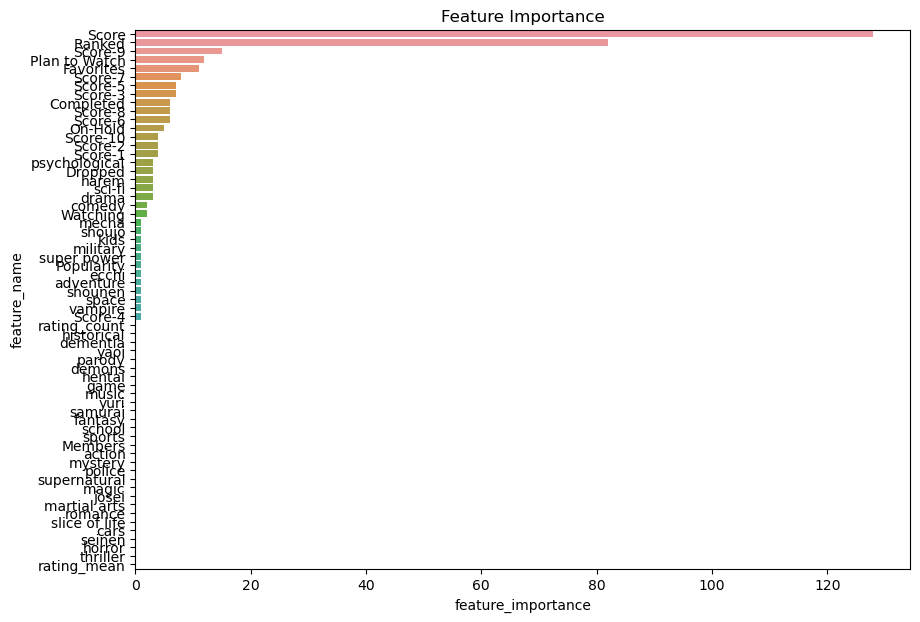

In [112]:
plt.figure(figsize = (10,7))
plot_df = pd.DataFrame({'feature_name':features,'feature_importance':model_with_best_params.feature_importances_}).sort_values('feature_importance', ascending=False)
sns.barplot(x='feature_importance', y='feature_name',data=plot_df)
plt.title('Feature Importance')
plt.show()

In [125]:
model_with_best_params.predict(test.iloc[:10][features])

array([ 2.3347664 ,  1.4132639 ,  0.172364  , -1.17493269,  0.84473536,
       -1.59519146, -0.57551817, -1.16227338, -0.26352197,  0.58537936])

In [126]:
def recommend_for_user(user, model, k, sample_anime_num):
    anime = pd.read_csv('../data/anime.csv')
    pred_df = anime.sample(sample_anime_num).reset_index(drop=True) # sample recommend candidates
    rating = pd.read_csv('../data/rating_complete.csv')

    # preprocess for model prediction
    user_df = rating.query('user_id==@user')
    user_df = create_user_features(user_df)
    for col in user_df.columns:
        if col in features:
            pred_df[col] = user_df[col].values[0]
    pred_df = make_anime_score_rank_float(pred_df)
    pred_df = add_genre_to_features(pred_df)

    # recommend
    preds = model_with_best_params.predict(pred_df[features])    
    topk_idx = np.argsort(preds)[::-1][:k]
    recommend_df = pred_df.loc[topk_idx].reset_index(drop=True)

    # check recommend
    print('---------- Recommend ----------')
    for i, row in recommend_df.iterrows():
        print(f'{i+1}:{row["English name"]} : {row["Japanese name"]} : {row["Genres"]} : {row["Score"]}')

    print('---------- Actual ----------')
    user_df = user_df.merge(anime, left_on='anime_id', right_on='MAL_ID', how='inner').sort_values('rating',ascending=False)
    for i, row in user_df.head(10).iterrows():
        print(f'{row["English name"]} : {row["Genres"]} : {row["Score"]}')    

    return recommend_df

In [123]:
r = recommend_for_user(266729,model_with_best_params,15,10000)

---------- Recommend ----------
1:Attack on Titan Final Season : 進撃の巨人 The Final Season : Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen : 9.17
2:Fullmetal Alchemist:Brotherhood : 鋼の錬金術師 FULLMETAL ALCHEMIST : Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen : 9.19
3:Steins;Gate : STEINS;GATE : Thriller, Sci-Fi : 9.11
4:Gintama Season 4 : 銀魂° : Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen : 9.1
5:Gintama Season 2 : 銀魂' : Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen : 9.08
6:Gintama:Enchousen : 銀魂' 延長戦 : Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen : 9.04
7:March Comes In Like A Lion 2nd Season : 3月のライオン 第2シリーズ : Drama, Game, Seinen, Slice of Life : 9.0
8:Owarimonogatari Second Season : 終物語 : Mystery, Comedy, Supernatural, Vampire : 8.93
9:Gintama : 銀魂 : Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen : 8.96
10:Code Geass:Lelouch of the Rebellion R2 : コードギアス 反逆のルルーシュ 続編 : Action, Military, Sc